In [185]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from statsmodels.formula.api import ols
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt  # To visualize
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

In [186]:
# Deep Learning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
from keras.optimizers import Adam
import keras
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 

from tensorflow import keras
import keras_tuner as kt

In [187]:
# Declaring global variables
RQUARE_CUTOFF = 0.7 # Min R-square value set to 75%
SIGMA = 2  # Number of standard deviation. 2-sigma
regressors = {}

In [188]:
# Read CSv file and Return dataframe given module ID from the user
def get_csv(user_input):
    pathname = "Data/test_samples/" + user_input + ".csv"
    df = pd.read_csv(Path(pathname), header=1, usecols = ['TIMESTAMP', 'AirTemp_Avg', 'Irradiance_Pyr_NOCT_Avg', 'Wind_speed', 'Wind_direction', 'NOCT_Mod1_Cent1_Avg', 'NOCT_Mod1_Cent2_Avg'])
    #df = pd.read_csv(Path(pathname))

    return df

In [189]:
# Function that takes a directory pathname and returns the list of csv files in that directory
def get_csvfiles(pathname):
    dir_path = Path(pathname)
    csvfile = []
    p = dir_path.glob('*.csv')
    files = [x for x in p if x.is_file()]
    for f in files:
        for part in f.parts:
            if not part.startswith('.') and part.endswith('.csv'):
                csvfile.append(part)
    return csvfile

In [190]:
# This function takes the absolute or relative pathname to the data directory,
# Then create and return a list of dataframes
def get_dataframes(dir_pathname):
    dataframes = []
    csv_filenames = get_csvfiles(dir_pathname)
    for file in csv_filenames:
        table_name = file.split('.')[0]
        df = pd.read_csv(Path(dir_pathname + file), header=1, usecols = ['TIMESTAMP', 'AirTemp_Avg', 'Irradiance_Pyr_NOCT_Avg', 'Wind_speed', 'Wind_direction', 'NOCT_Mod1_Cent1_Avg', 'NOCT_Mod1_Cent2_Avg'])
        #df = pd.read_csv(Path(dir_pathname + file))
        dataframes.append(df)
    return dataframes

In [191]:
# This function takes a dataframe and split into a list of dataframes to obtain daily data

def split_df(df):
    df_lst = []  # declare the list to return
    df['date'] = df['date'].astype(str)  # convert date column to string
    dates = df['date'].unique().tolist() # store unique dates into a list
    for Date in dates:
        df_lst.append(df.loc[df['date'].str.contains(Date)])   # create and append df of rows that contain the date string
        
    return df_lst

In [192]:
# user define function
def model_builder(hp):
        
    # first layer of the model
    model = keras.Sequential([tf.keras.layers.InputLayer(input_shape=4,)])
    # specifying the min and max nodes for hidden layer
    hp_units = hp.Int('units', min_value=10, max_value=100)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # output layer
    model.add(keras.layers.Dense(1, activation="linear"))
    #compiling the model
    model.compile(optimizer=keras.optimizers.SGD(),
                    loss='mean_squared_error')
    return model

In [193]:
# Create model
def create_model():
    model = Sequential()
    model.add(Dense(64, activation="relu", input_dim=4))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(4, activation="relu"))
    
    # Since the regression is performed, a Dense layer containing a single neuron with a linear activation function.
    # Typically ReLu-based activation are used but since it performs regression, it needs a linear activation.
    model.add(Dense(1, activation="linear"))
    
    # Compile model: The model is initialized with the Adam optimizer and then it is compiled.
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))
    
    return model

In [194]:
# Train the model
def fit_model(model, monitor, epoch):
    # Patient early stopping
    es = EarlyStopping(monitor=monitor, mode='min', verbose=1, patience=200)
    
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch, batch_size=100, verbose=2, callbacks=[es])
    
    return history

In [195]:
# Saving the model
def saving_model(model, filename):
    # Save a model using the HDF5 format
    model.save(filename)

In [196]:
# Saving history
def saving_history(history, filepath):
    # Get the dictionary containing each metric and the loss for each epoch
    history_dict = history.history
    # Save it under the form of a json file
    json.dump(history_dict, open(filepath, 'w'))

In [197]:
# Load a model from the HDF5 format
def loading_model(filename):
    loaded_h5_model = tf.keras.models.load_model(filename)
    
    return loaded_h5_model

In [198]:
# Load history from the json format
def loading_history(filename):
    history_dict = json.load(open(filename, 'r'))
    
    return history_dict

In [199]:
# Calculate predictions
def calculate_predictions(model):
    predictions = {}
    predictions['train'] = model.predict(X_train)
    predictions['test'] = model.predict(X_test)
    
    return predictions

In [200]:
# Plot training history
def plot_training(history_dict, filepath):
    plt.plot(history_dict['loss'], label='train')
    plt.plot(history_dict['val_loss'], label='test')
    plt.legend()
    plt.savefig(filepath)

In [201]:
# Plot actual vs prediction
def actual_prediction_plot(y, prediction_set, title, filepath):
    plt.plot(y,prediction_set,'ro')
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig(filepath)

In [202]:
# Compute scores value for a set
def compute_metrics(y, prediction_set):
    scores = []
    scores.append(metrics.r2_score(y,prediction_set))
    scores.append(metrics.mean_squared_error(y,prediction_set))
    
    return scores

In [203]:
# Compute NOCT value
def compute_noct(model):
    x = pd.DataFrame(columns=['irradiance', 'wind_speed', 'wind_direction', 'ambient_temperature'])
    x.loc[0] = [800,1,120,20]
    x = np.asarray(x)
    x=tf.convert_to_tensor(x, dtype=tf.int32)
    y_pred = model.predict(x)
    noct = float("{:.2f}".format( y_pred[0][0] ))
    
    return noct

In [204]:
'''
directory_pathname = "Data/Control_Module/"
dataframes = get_dataframes(directory_pathname)
combined_data = pd.concat(dataframes, axis=0, join='inner')
combined_data
'''

user_input = "CRS0018"
plotpath = 'plots/dnn_noct_' + user_input
combined_data = get_csv(user_input)
combined_data

C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:10: DtypeWarning: Columns (0,4,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  # Remove the CWD from sys.path while we load stuff.


,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,TS,NaN,NaN,Deg,NaN,Deg C,Deg C
1,1,3.0,4.00,5,7.0,17,18
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/21/2021 6:10:40,14.5,0.24,289,0.0,11.27,11.29
4,10/21/2021 6:10:45,14.5,0.21,305,0.0,11.29,11.3
...,...,...,...,...,...,...,...
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315734,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315735,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [205]:
# Drop rows.
# Could also use labels: noct_csv.drop(labels=[0,1], axis=0)
combined_data.drop(combined_data.index[[0,1]], axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/21/2021 6:10:40,14.5,0.24,289,0.0,11.27,11.29
4,10/21/2021 6:10:45,14.5,0.21,305,0.0,11.29,11.3
5,10/21/2021 6:10:50,14.5,0.26,276,0.0,11.32,11.32
6,10/21/2021 6:10:55,14.5,0.33,316,0.0,11.3,11.32
...,...,...,...,...,...,...,...
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315734,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315735,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
# Change "NAN" values to NaN so they can be dropped
combined_data.replace("NAN", np.NaN, inplace=True)

In [207]:
# Drop the previous index and reset 
combined_data.reset_index(drop=True, inplace=True)
combined_data.head()

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10/21/2021 6:10:40,14.5,0.24,289,0.0,11.27,11.29
2,10/21/2021 6:10:45,14.5,0.21,305,0.0,11.29,11.3
3,10/21/2021 6:10:50,14.5,0.26,276,0.0,11.32,11.32
4,10/21/2021 6:10:55,14.5,0.33,316,0.0,11.3,11.32


In [208]:
# Check data types
combined_data.dtypes

TIMESTAMP                   object
AirTemp_Avg                float64
Wind_speed                 float64
Wind_direction              object
Irradiance_Pyr_NOCT_Avg    float64
NOCT_Mod1_Cent1_Avg         object
NOCT_Mod1_Cent2_Avg         object
dtype: object

In [209]:
# Convert numeric columns to float
data = ['AirTemp_Avg', 'Irradiance_Pyr_NOCT_Avg', 'Wind_speed', 'Wind_direction', 'NOCT_Mod1_Cent1_Avg', 'NOCT_Mod1_Cent2_Avg']
for col in data:
    combined_data[col] = combined_data[col].astype('float')
combined_data.dtypes

TIMESTAMP                   object
AirTemp_Avg                float64
Wind_speed                 float64
Wind_direction             float64
Irradiance_Pyr_NOCT_Avg    float64
NOCT_Mod1_Cent1_Avg        float64
NOCT_Mod1_Cent2_Avg        float64
dtype: object

In [210]:
# Delete all data outside the range 0.25 < wind speed < 1.75
indexWS = combined_data[ (combined_data['Wind_speed']<0.25) | (combined_data['Wind_speed']>1.75) ].index  # get index of the desired rows to drop
combined_data.drop(indexWS, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10/21/2021 6:10:50,14.5,0.26,276.0,0.0,11.32,11.32
4,10/21/2021 6:10:55,14.5,0.33,316.0,0.0,11.30,11.32
5,10/21/2021 6:11:00,14.5,0.39,299.0,0.0,11.30,11.32
13,10/21/2021 6:11:40,14.5,0.30,330.0,0.0,11.30,11.35
...,...,...,...,...,...,...,...
315730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [211]:
# Delete all Wind Direction data within 290 - 250, and 69 - 110
indexWD = combined_data[ ((combined_data['Wind_direction']>250) & (combined_data['Wind_direction']<=290)) | ((combined_data['Wind_direction']>69.99) & (combined_data['Wind_direction']<=110)) ].index  
combined_data.drop(indexWD, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10/21/2021 6:10:55,14.5,0.33,316.0,0.0,11.30,11.32
5,10/21/2021 6:11:00,14.5,0.39,299.0,0.0,11.30,11.32
13,10/21/2021 6:11:40,14.5,0.30,330.0,0.0,11.30,11.35
14,10/21/2021 6:11:45,14.5,0.36,334.0,0.0,11.29,11.32
...,...,...,...,...,...,...,...
315730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
# Delete all Irradiance data below 400 and above 1100
indexIrr = combined_data[ (combined_data['Irradiance_Pyr_NOCT_Avg']<400) | (combined_data['Irradiance_Pyr_NOCT_Avg']>1100) ].index
combined_data.drop(indexIrr, axis=0, inplace=True)
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1353,10/21/2021 8:04:45,18.7,0.87,234.0,400.9399,32.06,31.58
1354,10/21/2021 8:04:50,18.7,0.41,249.0,400.9399,32.12,31.65
1355,10/21/2021 8:04:55,18.7,0.55,341.0,401.9360,32.15,31.78
1356,10/21/2021 8:05:00,18.7,0.37,7.0,401.9360,32.23,31.93
...,...,...,...,...,...,...,...
315730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
# Create the T-rise and module_temperature columns
combined_data['module_temperature'] = combined_data[['NOCT_Mod1_Cent1_Avg','NOCT_Mod1_Cent2_Avg']].mean(axis=1)
combined_data['T_RISE'] = combined_data[['NOCT_Mod1_Cent1_Avg','NOCT_Mod1_Cent2_Avg']].mean(axis=1) - combined_data['AirTemp_Avg']
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1353,10/21/2021 8:04:45,18.7,0.87,234.0,400.9399,32.06,31.58,31.820,13.120
1354,10/21/2021 8:04:50,18.7,0.41,249.0,400.9399,32.12,31.65,31.885,13.185
1355,10/21/2021 8:04:55,18.7,0.55,341.0,401.9360,32.15,31.78,31.965,13.265
1356,10/21/2021 8:05:00,18.7,0.37,7.0,401.9360,32.23,31.93,32.080,13.380
...,...,...,...,...,...,...,...,...,...
315730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
combined_data["Date"] = pd.to_datetime(combined_data["TIMESTAMP"])
display(combined_data.dtypes)
display(combined_data.head(5))

TIMESTAMP                          object
AirTemp_Avg                       float64
Wind_speed                        float64
Wind_direction                    float64
Irradiance_Pyr_NOCT_Avg           float64
NOCT_Mod1_Cent1_Avg               float64
NOCT_Mod1_Cent2_Avg               float64
module_temperature                float64
T_RISE                            float64
Date                       datetime64[ns]
dtype: object

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1353,10/21/2021 8:04:45,18.7,0.87,234.0,400.9399,32.06,31.58,31.820,13.120,2021-10-21 08:04:45
1354,10/21/2021 8:04:50,18.7,0.41,249.0,400.9399,32.12,31.65,31.885,13.185,2021-10-21 08:04:50
1355,10/21/2021 8:04:55,18.7,0.55,341.0,401.9360,32.15,31.78,31.965,13.265,2021-10-21 08:04:55
1356,10/21/2021 8:05:00,18.7,0.37,7.0,401.9360,32.23,31.93,32.080,13.380,2021-10-21 08:05:00


In [215]:
combined_data["date"] = combined_data["Date"].dt.date
combined_data["year"] = combined_data["Date"].dt.year
combined_data["month"] = combined_data["Date"].dt.month
combined_data["day"] = combined_data["Date"].dt.day
combined_data["hour"] = combined_data["Date"].dt.hour
combined_data["minute"] = combined_data["Date"].dt.minute
#noct_csv.drop("TIMESTAMP", axis=1, inplace=True)
combined_data.head(5)

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
1353,10/21/2021 8:04:45,18.7,0.87,234.0,400.9399,32.06,31.58,31.820,13.120,2021-10-21 08:04:45,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1354,10/21/2021 8:04:50,18.7,0.41,249.0,400.9399,32.12,31.65,31.885,13.185,2021-10-21 08:04:50,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1355,10/21/2021 8:04:55,18.7,0.55,341.0,401.9360,32.15,31.78,31.965,13.265,2021-10-21 08:04:55,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1356,10/21/2021 8:05:00,18.7,0.37,7.0,401.9360,32.23,31.93,32.080,13.380,2021-10-21 08:05:00,2021-10-21,2021.0,10.0,21.0,8.0,5.0


In [216]:
combined_data.dropna(axis=0, how='any', inplace=True)
combined_data.sort_values(by=['Date'])
combined_data

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
1353,10/21/2021 8:04:45,18.7,0.87,234.0,400.9399,32.06,31.58,31.820,13.120,2021-10-21 08:04:45,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1354,10/21/2021 8:04:50,18.7,0.41,249.0,400.9399,32.12,31.65,31.885,13.185,2021-10-21 08:04:50,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1355,10/21/2021 8:04:55,18.7,0.55,341.0,401.9360,32.15,31.78,31.965,13.265,2021-10-21 08:04:55,2021-10-21,2021.0,10.0,21.0,8.0,4.0
1356,10/21/2021 8:05:00,18.7,0.37,7.0,401.9360,32.23,31.93,32.080,13.380,2021-10-21 08:05:00,2021-10-21,2021.0,10.0,21.0,8.0,5.0
1357,10/21/2021 8:05:05,18.7,0.52,205.0,402.4341,32.34,31.93,32.135,13.435,2021-10-21 08:05:05,2021-10-21,2021.0,10.0,21.0,8.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105957,10/28/2021 8:52:05,20.0,0.26,52.0,613.4058,41.56,40.83,41.195,21.195,2021-10-28 08:52:05,2021-10-28,2021.0,10.0,28.0,8.0,52.0
105958,10/28/2021 8:52:10,20.0,0.46,149.0,613.9037,41.52,40.78,41.150,21.150,2021-10-28 08:52:10,2021-10-28,2021.0,10.0,28.0,8.0,52.0
105959,10/28/2021 8:52:15,20.1,0.27,32.0,614.8995,41.65,41.06,41.355,21.255,2021-10-28 08:52:15,2021-10-28,2021.0,10.0,28.0,8.0,52.0
105960,10/28/2021 8:52:20,20.1,0.52,229.0,614.8995,41.72,41.24,41.480,21.380,2021-10-28 08:52:20,2021-10-28,2021.0,10.0,28.0,8.0,52.0


In [217]:
# Slice data between 11am and 1pm
indexHour = combined_data[ ((combined_data['hour']<11) | (combined_data['hour']>13))].index
combined_data.drop(indexHour, axis=0, inplace=True)

In [218]:
# Split the data into a list of daily data
noct_dataframes = split_df(combined_data)
noct_dataframes[0]

,TIMESTAMP,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,NOCT_Mod1_Cent1_Avg,NOCT_Mod1_Cent2_Avg,module_temperature,T_RISE,Date,date,year,month,day,hour,minute
3456,10/21/2021 11:00:00,28.2,1.20,235.0,965.7471,59.95,59.64,59.795,31.595,2021-10-21 11:00:00,2021-10-21,2021.0,10.0,21.0,11.0,0.0
3457,10/21/2021 11:00:05,28.2,1.74,221.0,964.7520,60.40,60.06,60.230,32.030,2021-10-21 11:00:05,2021-10-21,2021.0,10.0,21.0,11.0,0.0
3459,10/21/2021 11:00:15,28.1,1.19,210.0,965.7471,59.99,59.96,59.975,31.875,2021-10-21 11:00:15,2021-10-21,2021.0,10.0,21.0,11.0,0.0
3464,10/21/2021 11:00:40,28.1,1.05,120.0,965.7471,60.12,59.79,59.955,31.855,2021-10-21 11:00:40,2021-10-21,2021.0,10.0,21.0,11.0,0.0
3465,10/21/2021 11:00:45,28.1,0.81,307.0,966.7422,59.71,59.31,59.510,31.410,2021-10-21 11:00:45,2021-10-21,2021.0,10.0,21.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5609,10/21/2021 13:59:25,31.1,1.18,300.0,894.8112,61.24,60.56,60.900,29.800,2021-10-21 13:59:25,2021-10-21,2021.0,10.0,21.0,13.0,59.0
5611,10/21/2021 13:59:35,31.1,0.58,136.0,893.3182,61.58,60.55,61.065,29.965,2021-10-21 13:59:35,2021-10-21,2021.0,10.0,21.0,13.0,59.0
5613,10/21/2021 13:59:45,31.1,1.34,161.0,894.3135,61.51,60.43,60.970,29.870,2021-10-21 13:59:45,2021-10-21,2021.0,10.0,21.0,13.0,59.0
5614,10/21/2021 13:59:50,31.1,0.71,123.0,893.8159,61.58,60.84,61.210,30.110,2021-10-21 13:59:50,2021-10-21,2021.0,10.0,21.0,13.0,59.0


In [219]:
# Aggregate data by minutes
daily_noct = []
for dataframe in noct_dataframes:
    noct_df = dataframe[["date", "hour","minute", "month", "AirTemp_Avg", "Wind_speed", "Wind_direction", "Irradiance_Pyr_NOCT_Avg", "module_temperature", "T_RISE"]]
    noct_df_agg = noct_df.groupby(["date", "hour", "minute"]).mean()
    noct_df_agg.reset_index(inplace=True)
    daily_noct.append(noct_df_agg)

daily_noct[0]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2021-10-21,11.0,0.0,10.0,28.128571,1.211429,222.428571,966.031414,59.912857,31.784286
1,2021-10-21,11.0,1.0,10.0,28.100000,0.887000,285.800000,967.787070,59.234500,31.134500
2,2021-10-21,11.0,2.0,10.0,28.100000,0.785000,219.999999,968.682440,59.147000,31.047000
3,2021-10-21,11.0,3.0,10.0,28.025000,0.886250,214.500000,970.535787,59.564375,31.539375
4,2021-10-21,11.0,4.0,10.0,27.850000,0.686250,236.875000,971.717313,59.745625,31.895625
...,...,...,...,...,...,...,...,...,...,...
175,2021-10-21,13.0,55.0,10.0,31.066667,1.310000,113.333332,907.494317,60.798333,29.731667
176,2021-10-21,13.0,56.0,10.0,31.175000,1.200000,132.250000,905.631600,60.283750,29.108750
177,2021-10-21,13.0,57.0,10.0,31.300000,0.987500,147.750000,903.143250,60.411250,29.111250
178,2021-10-21,13.0,58.0,10.0,31.214286,0.587143,168.857143,898.934714,60.595714,29.381429


In [220]:
len(daily_noct)

6

In [221]:
# Cleaning ambient temperatures
# If min amb temp around 35, delete data where (max - min) amb temp are above 5 degC
# Otherwise, Delete all Ambient Temperature data below 5 degC and above 35 degC if max Tamb < 35
for noct in daily_noct:
    indexShift = noct[ (noct['AirTemp_Avg'] - noct['AirTemp_Avg'].shift(1)) < 0 ].index
    noct.drop(indexShift, axis=0, inplace=True)
    if noct['AirTemp_Avg'].min() >= 35:
        while (noct['AirTemp_Avg'].max() - noct['AirTemp_Avg'].min()) > 5:
            noct.drop(noct[(noct['AirTemp_Avg'] == noct['AirTemp_Avg'].max()) | (noct["AirTemp_Avg"] == noct['AirTemp_Avg'].min())].index, axis=0, inplace=True)
    else:
        indexTamb = noct[ ((noct['AirTemp_Avg']<5) & (noct['AirTemp_Avg']>35))].index
        noct.drop(indexTamb, axis=0, inplace=True)
    #print(f"{noct.index[0][0]}: \n{noct}")

In [222]:
# Indice 5 is known to have only afternoon data. This should be removed
daily_noct[5]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2021-10-27,11.0,0.0,10.0,21.920000,1.307000,127.500000,972.140060,55.059000,33.139000
3,2021-10-27,11.0,3.0,10.0,21.877778,0.768889,136.333333,977.096056,55.075000,33.197222
4,2021-10-27,11.0,4.0,10.0,22.033333,0.710000,190.888889,979.308867,55.682222,33.648889
5,2021-10-27,11.0,5.0,10.0,22.177778,0.548889,261.444444,981.185833,55.457222,33.279444
6,2021-10-27,11.0,6.0,10.0,22.325000,0.733750,162.750000,983.077100,54.589375,32.264375
...,...,...,...,...,...,...,...,...,...,...
175,2021-10-27,13.0,55.0,10.0,24.887500,0.740000,122.500000,889.558325,58.576250,33.688750
176,2021-10-27,13.0,56.0,10.0,25.055556,1.141111,132.222222,887.077578,57.923333,32.867778
177,2021-10-27,13.0,57.0,10.0,25.100000,0.457500,213.750000,884.645075,58.155000,33.055000
178,2021-10-27,13.0,58.0,10.0,25.100000,0.602000,70.200000,882.555260,58.208000,33.108000


In [223]:
# We want to delete all the data which do not have points before and after noon
to_remove = []   # This will hold the indices of the dataframe list to be removed
for i, noct in enumerate(daily_noct):
    am = False
    pm = False
    if noct['hour'].min() == 11:
        am = True
    if noct['hour'].max() in [12,13]:
        pm = True
    if (am == False or pm == False):
        to_remove.append(i)
# Sort the indice of dataframes to drop
# By starting from higher to lower indices, we're guaranteed that the indices on the dataframe will remain unmodified while deleting
for x in sorted(to_remove, reverse=True):
    del daily_noct[x]

In [224]:
# Checking that the previous indice 5 was effectively deleted.
daily_noct[5]

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2021-10-27,11.0,0.0,10.0,21.920000,1.307000,127.500000,972.140060,55.059000,33.139000
3,2021-10-27,11.0,3.0,10.0,21.877778,0.768889,136.333333,977.096056,55.075000,33.197222
4,2021-10-27,11.0,4.0,10.0,22.033333,0.710000,190.888889,979.308867,55.682222,33.648889
5,2021-10-27,11.0,5.0,10.0,22.177778,0.548889,261.444444,981.185833,55.457222,33.279444
6,2021-10-27,11.0,6.0,10.0,22.325000,0.733750,162.750000,983.077100,54.589375,32.264375
...,...,...,...,...,...,...,...,...,...,...
175,2021-10-27,13.0,55.0,10.0,24.887500,0.740000,122.500000,889.558325,58.576250,33.688750
176,2021-10-27,13.0,56.0,10.0,25.055556,1.141111,132.222222,887.077578,57.923333,32.867778
177,2021-10-27,13.0,57.0,10.0,25.100000,0.457500,213.750000,884.645075,58.155000,33.055000
178,2021-10-27,13.0,58.0,10.0,25.100000,0.602000,70.200000,882.555260,58.208000,33.108000


In [225]:
len(daily_noct)

6

In [226]:
'''
# Set the dependent and independent variables list for the model.
# Multiple linear regression: T_RISE = f(Irradiance, Wind_speed)
target = "module_temperature"
feature_names = ['irradiance', 'wind_speed', 'wind_direction', 'ambient_temperature']
full_model_dict = {}


for noct in daily_noct:
    # Rename columns
    noct.rename(columns={'AirTemp_Avg':'ambient_temperature', 'Wind_speed':'wind_speed', 'Wind_direction':'wind_direction', 'Irradiance_Pyr_NOCT_Avg':'irradiance'}, inplace=True)
    # Split into training and testing windows
    X_train, X_test, y_train, y_test = train_test_split(noct[feature_names], noct[target], random_state=11)
    
    # Let's set the model training for a very long time, 
    # but with an EarlyStopping callback so it stops automatically when it stops improving.
    model = create_model()
    history = fit_model(model, 'val_loss', 100000)
    
    # define filename for saving the model
    s = noct['date'].unique()[0]
    filepath = 'models/dnn_noct_' + s
    
    # Save a model using the HDF5 format
    saving_model(model, filepath+'.h5')
    saving_history(history, filepath)
 '''   


'\n# Set the dependent and independent variables list for the model.\n# Multiple linear regression: T_RISE = f(Irradiance, Wind_speed)\ntarget = "module_temperature"\nfeature_names = [\'irradiance\', \'wind_speed\', \'wind_direction\', \'ambient_temperature\']\nfull_model_dict = {}\n\n\nfor noct in daily_noct:\n    # Rename columns\n    noct.rename(columns={\'AirTemp_Avg\':\'ambient_temperature\', \'Wind_speed\':\'wind_speed\', \'Wind_direction\':\'wind_direction\', \'Irradiance_Pyr_NOCT_Avg\':\'irradiance\'}, inplace=True)\n    # Split into training and testing windows\n    X_train, X_test, y_train, y_test = train_test_split(noct[feature_names], noct[target], random_state=11)\n    \n    # Let\'s set the model training for a very long time, \n    # but with an EarlyStopping callback so it stops automatically when it stops improving.\n    model = create_model()\n    history = fit_model(model, \'val_loss\', 100000)\n    \n    # define filename for saving the model\n    s = noct[\'date\']

In [227]:
'''
model = loading_model('models/dnn_noct_2023-06-01.h5')
model.summary()
'''

"\nmodel = loading_model('models/dnn_noct_2023-06-01.h5')\nmodel.summary()\n"

In [228]:
# history_dict = loading_history('models/dnn_noct_2023-06-01')

In [229]:
'''
# Calculate predictions
predictions = calculate_predictions(model)

# Plot training history
plot_training(history_dict, 'plots/dnn_noct_2023-06-01.png')
'''
'''
# Calculate predictions
PredTestSet = model.predict(X_train)
PredValSet = model.predict(X_test)
'''

'\n# Calculate predictions\nPredTestSet = model.predict(X_train)\nPredValSet = model.predict(X_test)\n'

In [230]:
# Combining the list of dataframes into a single one
combined_daily_noct = pd.concat(daily_noct, axis=0, join='inner')
combined_daily_noct

,date,hour,minute,month,AirTemp_Avg,Wind_speed,Wind_direction,Irradiance_Pyr_NOCT_Avg,module_temperature,T_RISE
0,2021-10-21,11.0,0.0,10.0,28.128571,1.211429,222.428571,966.031414,59.912857,31.784286
2,2021-10-21,11.0,2.0,10.0,28.100000,0.785000,219.999999,968.682440,59.147000,31.047000
6,2021-10-21,11.0,6.0,10.0,27.850000,1.263750,321.750000,974.267025,59.566875,31.716875
7,2021-10-21,11.0,7.0,10.0,28.045455,1.117273,324.272727,974.747636,60.137727,32.092273
8,2021-10-21,11.0,8.0,10.0,28.255556,1.244444,319.222222,975.863278,59.935556,31.680000
...,...,...,...,...,...,...,...,...,...,...
175,2021-10-27,13.0,55.0,10.0,24.887500,0.740000,122.500000,889.558325,58.576250,33.688750
176,2021-10-27,13.0,56.0,10.0,25.055556,1.141111,132.222222,887.077578,57.923333,32.867778
177,2021-10-27,13.0,57.0,10.0,25.100000,0.457500,213.750000,884.645075,58.155000,33.055000
178,2021-10-27,13.0,58.0,10.0,25.100000,0.602000,70.200000,882.555260,58.208000,33.108000


In [231]:
# Simple Regression using T_RISE
'''
# Set the dependent and independent variables list for the model.
# Simple linear regression: T_RISE = f(Irradiance)
model = LinearRegression(fit_intercept=True)
model_dict = {}
x = combined_daily_noct.loc[:, "Irradiance_Pyr_NOCT_Avg"].values.reshape(-1, 1)  # values converts it into a numpy array
y = combined_daily_noct.loc[:, "T_RISE"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
model.fit(x, y)
combined_daily_noct['predicted'] = model.predict(x)
noct_est = 20 + model.intercept_ + model.coef_ * 800
plot = combined_daily_noct.hvplot.scatter(x='Irradiance_Pyr_NOCT_Avg',
                               y='T_RISE',
                               xlabel = "Irradiance",
                               ylabel="Temperature Rise",
                               title=f"Temp Rise vs. Irradiance for {combined_daily_noct.index[0]}",
                               color="blue"
                               ).opts(yformatter='%.0f') * combined_daily_noct.hvplot.line(x='Irradiance_Pyr_NOCT_Avg',
                                                                                       y='predicted',
                                                                                       color='red')
#model_dict[all_noct.index[0]] = {"model": model, "plot": plot, "intercept": round(float(model.intercept_),2), "slope": round(float(model.coef_),2), "noct": noct_est, "r_square": round(float(model.score(x, y)),2)}
'''

'\n# Set the dependent and independent variables list for the model.\n# Simple linear regression: T_RISE = f(Irradiance)\nmodel = LinearRegression(fit_intercept=True)\nmodel_dict = {}\nx = combined_daily_noct.loc[:, "Irradiance_Pyr_NOCT_Avg"].values.reshape(-1, 1)  # values converts it into a numpy array\ny = combined_daily_noct.loc[:, "T_RISE"].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column\nmodel.fit(x, y)\ncombined_daily_noct[\'predicted\'] = model.predict(x)\nnoct_est = 20 + model.intercept_ + model.coef_ * 800\nplot = combined_daily_noct.hvplot.scatter(x=\'Irradiance_Pyr_NOCT_Avg\',\n                               y=\'T_RISE\',\n                               xlabel = "Irradiance",\n                               ylabel="Temperature Rise",\n                               title=f"Temp Rise vs. Irradiance for {combined_daily_noct.index[0]}",\n                               color="blue"\n                               ).opts(yformatter=\'%.0

In [232]:
# Multiple Regression using T_RISE
'''
# Set the dependent and independent variables list for the model.
# Multiple linear regression: T_RISE = f(Irradiance, Wind_speed)
full_model = LinearRegression(fit_intercept=True)
full_model_dict = {}

X = combined_daily_noct[['Wind_speed','Irradiance_Pyr_NOCT_Avg']]
Y = combined_daily_noct['T_RISE']
full_model = ols("Y ~ X", combined_daily_noct).fit()
#anova_results = anova_lm(model)
summary = full_model.summary()
results = full_model.params
r_square = full_model.rsquared
noct_est = 20 + results[0] + results[1] + results[2] * 800
Tamb_avg = float(combined_daily_noct["AirTemp_Avg"].mean())
WS_avg = float(combined_daily_noct["Wind_speed"].mean())
#full_model_dict[noct.index[0]] = {"model": model, "summary": summary, "parameters": results, "noct": noct_est, "r_square": r_square, "ambient_temp": Tamb_avg, "wind_speed": WS_avg, "ws_correction": int(results[1])}
'''

'\n# Set the dependent and independent variables list for the model.\n# Multiple linear regression: T_RISE = f(Irradiance, Wind_speed)\nfull_model = LinearRegression(fit_intercept=True)\nfull_model_dict = {}\n\nX = combined_daily_noct[[\'Wind_speed\',\'Irradiance_Pyr_NOCT_Avg\']]\nY = combined_daily_noct[\'T_RISE\']\nfull_model = ols("Y ~ X", combined_daily_noct).fit()\n#anova_results = anova_lm(model)\nsummary = full_model.summary()\nresults = full_model.params\nr_square = full_model.rsquared\nnoct_est = 20 + results[0] + results[1] + results[2] * 800\nTamb_avg = float(combined_daily_noct["AirTemp_Avg"].mean())\nWS_avg = float(combined_daily_noct["Wind_speed"].mean())\n#full_model_dict[noct.index[0]] = {"model": model, "summary": summary, "parameters": results, "noct": noct_est, "r_square": r_square, "ambient_temp": Tamb_avg, "wind_speed": WS_avg, "ws_correction": int(results[1])}\n'

In [233]:
'''
# Display Simple Linear Regression Results
#display(model_dict[key]['ws_correction'])
#display(model_dict[key]['ambient_temp'])
#display(model_dict[key]['wind_speed'])
display(noct_est)
display(round(float(model.score(x, y)),2))
print(" ")
display(plot)
'''

'\n# Display Simple Linear Regression Results\n#display(model_dict[key][\'ws_correction\'])\n#display(model_dict[key][\'ambient_temp\'])\n#display(model_dict[key][\'wind_speed\'])\ndisplay(noct_est)\ndisplay(round(float(model.score(x, y)),2))\nprint(" ")\ndisplay(plot)\n'

In [234]:
#combined_daily_noct.head(3)

In [235]:
combined_df = combined_daily_noct[['AirTemp_Avg', 'Wind_speed', 'Wind_direction', 'Irradiance_Pyr_NOCT_Avg', 'module_temperature', 'T_RISE']]
combined_df.rename(columns={'AirTemp_Avg':'ambient_temperature', 'Wind_speed':'wind_speed', 'Wind_direction':'wind_direction', 'Irradiance_Pyr_NOCT_Avg':'irradiance'}, inplace=True)
combined_df

C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ambient_temperature,wind_speed,wind_direction,irradiance,module_temperature,T_RISE
0,28.128571,1.211429,222.428571,966.031414,59.912857,31.784286
2,28.100000,0.785000,219.999999,968.682440,59.147000,31.047000
6,27.850000,1.263750,321.750000,974.267025,59.566875,31.716875
7,28.045455,1.117273,324.272727,974.747636,60.137727,32.092273
8,28.255556,1.244444,319.222222,975.863278,59.935556,31.680000
...,...,...,...,...,...,...
175,24.887500,0.740000,122.500000,889.558325,58.576250,33.688750
176,25.055556,1.141111,132.222222,887.077578,57.923333,32.867778
177,25.100000,0.457500,213.750000,884.645075,58.155000,33.055000
178,25.100000,0.602000,70.200000,882.555260,58.208000,33.108000


In [236]:
'''
X_train, X_test, y_train, y_test = train_test_split(combined_df.irradiance.values.reshape(-1,1), combined_df.T_RISE.values, random_state=11)
display(X_train.shape)
display(X_test.shape)
'''

'\nX_train, X_test, y_train, y_test = train_test_split(combined_df.irradiance.values.reshape(-1,1), combined_df.T_RISE.values, random_state=11)\ndisplay(X_train.shape)\ndisplay(X_test.shape)\n'

In [237]:
'''
linear_regression = LinearRegression()
linear_regression.fit(X=X_train, y=y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
'''

'\nlinear_regression = LinearRegression()\nlinear_regression.fit(X=X_train, y=y_train)\nLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)\n'

In [238]:
#display(linear_regression.coef_)
#display(linear_regression.intercept_)

In [239]:
#predicted = linear_regression.predict(X_test)
#expected = y_test
'''
for p, e in zip(predicted[::5], expected[::5]):
    print(f'predicted: {p:.2f}, expected: {e:.2f}')
'''

"\nfor p, e in zip(predicted[::5], expected[::5]):\n    print(f'predicted: {p:.2f}, expected: {e:.2f}')\n"

In [240]:
'''
noct = 20 + linear_regression.coef_* 800 + linear_regression.intercept_
print(f'R_SQUARE: {round(float(linear_regression.score(x, y)),2)}')
print(f'ESTIMATED_NOCT: {noct}')
'''

"\nnoct = 20 + linear_regression.coef_* 800 + linear_regression.intercept_\nprint(f'R_SQUARE: {round(float(linear_regression.score(x, y)),2)}')\nprint(f'ESTIMATED_NOCT: {noct}')\n"

In [241]:
#predict = (lambda x: linear_regression.coef_ * x + linear_regression.intercept_)

In [242]:
'''
# Visualizing the dataset with the Regression line
axes = sns.scatterplot(data=combined_df, x='irradiance', y='T_RISE', hue='T_RISE', palette='winter', legend=False)
#axes.set_ylim(400,1000)
x = np.array([min(combined_df.irradiance.values), max(combined_df.irradiance.values)])
y = predict(x)
line = plt.plot(x,y)
'''

"\n# Visualizing the dataset with the Regression line\naxes = sns.scatterplot(data=combined_df, x='irradiance', y='T_RISE', hue='T_RISE', palette='winter', legend=False)\n#axes.set_ylim(400,1000)\nx = np.array([min(combined_df.irradiance.values), max(combined_df.irradiance.values)])\ny = predict(x)\nline = plt.plot(x,y)\n"

# Multiple Linear Regression

In [243]:
target = "module_temperature"
feature_names = ['irradiance', 'wind_speed', 'wind_direction', 'ambient_temperature']

In [244]:
display(combined_df[feature_names].shape)
display(combined_df[target].shape)

(654, 4)

(654,)

In [245]:
sample_df = combined_df.sample(frac=0.1, random_state=17)

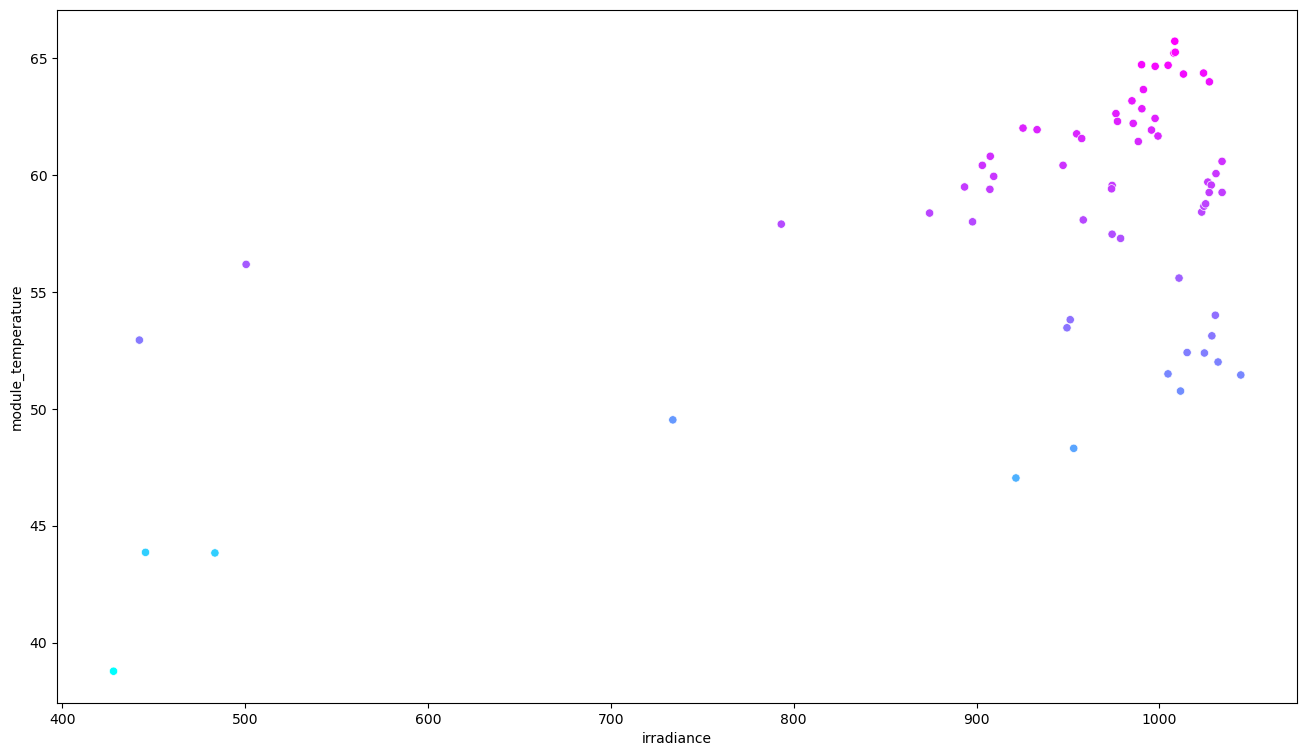

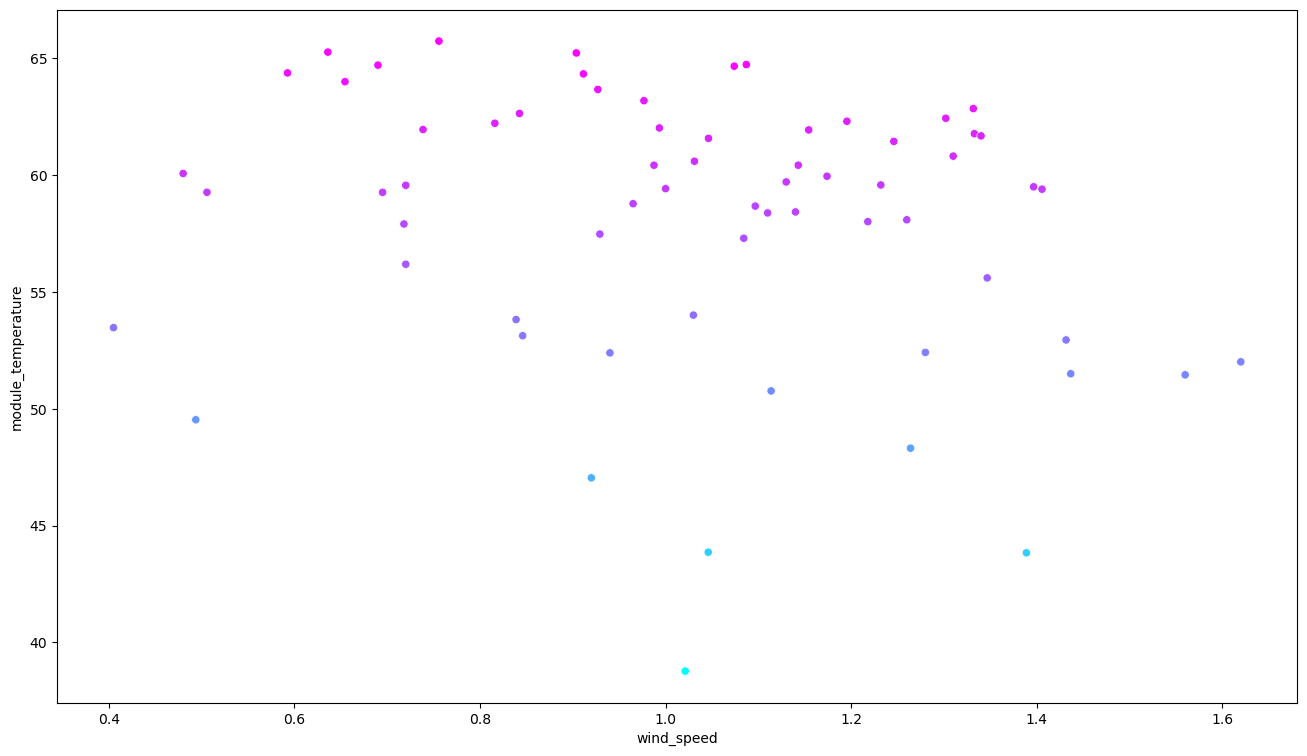

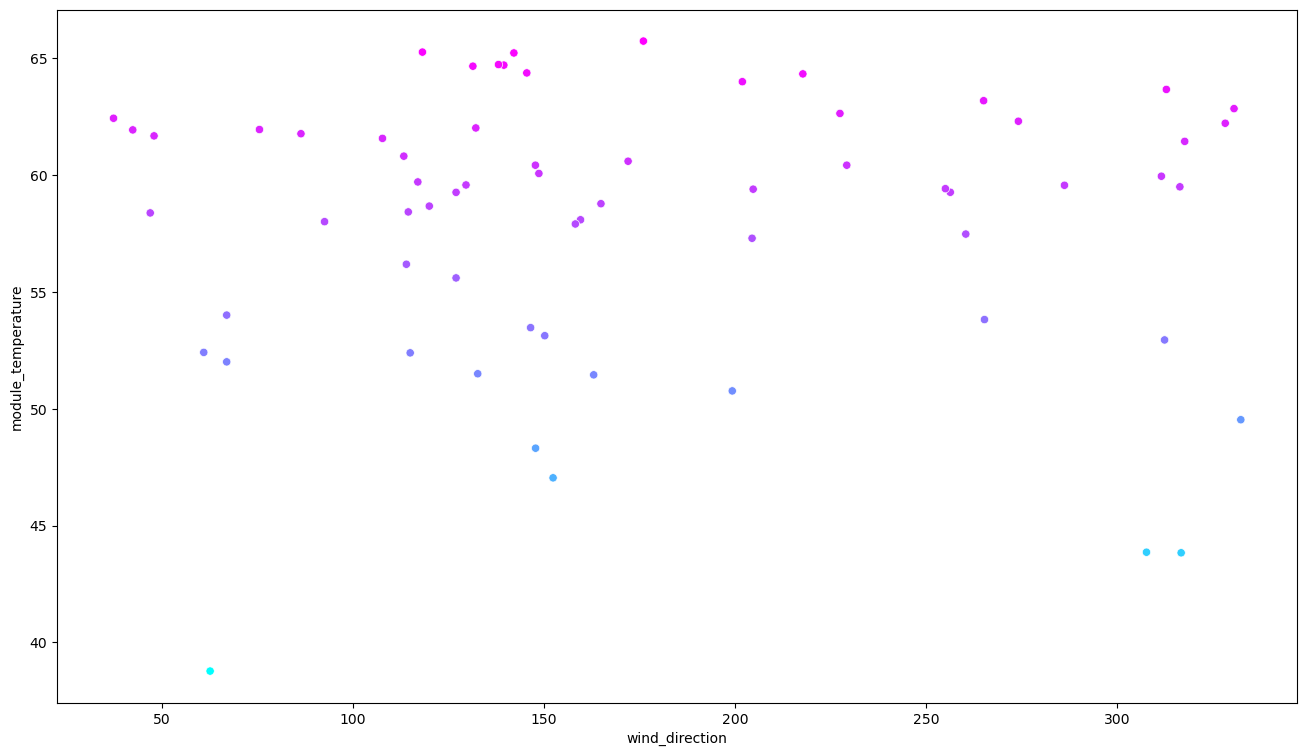

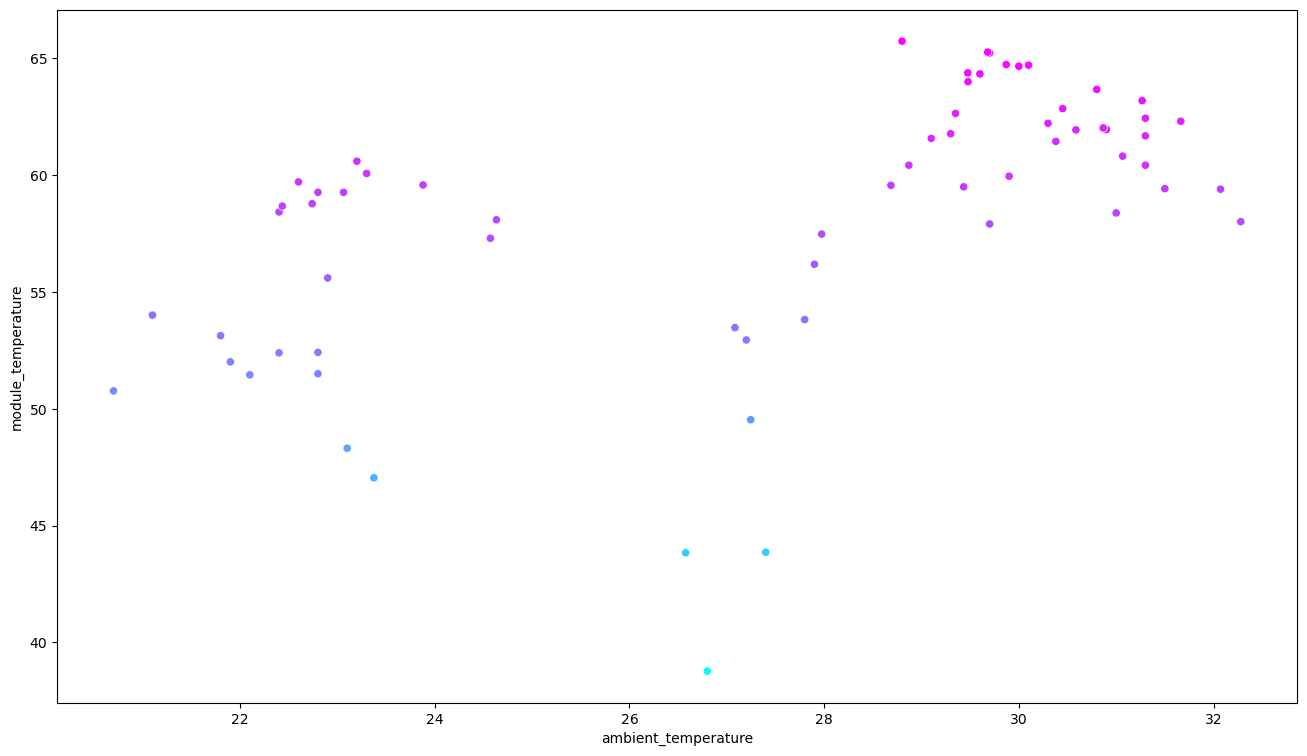

In [246]:
for feature in feature_names:
    plt.figure(figsize=(16,9))
    sns.scatterplot(data=sample_df, x=feature, y=target, hue=target, palette='cool', legend=False)

In [247]:
sample_df[feature_names].corr()

,irradiance,wind_speed,wind_direction,ambient_temperature
irradiance,1.000000,-0.062411,-0.224956,-0.153507
wind_speed,-0.062411,1.000000,-0.089551,-0.070079
wind_direction,-0.224956,-0.089551,1.000000,0.195585
ambient_temperature,-0.153507,-0.070079,0.195585,1.000000


In [248]:
X_train, X_test, y_train, y_test = train_test_split(combined_df[feature_names], combined_df[target], random_state=11)
display(X_train.shape)
display(X_test.shape)


(490, 4)

(164, 4)

In [249]:
linear_regression = LinearRegression()
linear_regression.fit(X=X_train, y=y_train)
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(normalize=False)

In [250]:
# Regression coefficients
for i, name in enumerate(feature_names):
    print(f'{name:>10}: {linear_regression.coef_[i]}')
linear_regression.intercept_

irradiance: 0.02816880588945468
wind_speed: -2.993670225202162
wind_direction: -0.0011938709748723164
ambient_temperature: 1.1632584508060255


2.962832054018037

In [251]:
# NOCT estimate
noct_est = linear_regression.intercept_ + 800*linear_regression.coef_[0] + 1*linear_regression.coef_[1] + 120*linear_regression.coef_[2] + 20*linear_regression.coef_[3]
noct_est

45.62611103951545

In [252]:
# Testing the model
predicted = linear_regression.predict(X_test)
expected = y_test

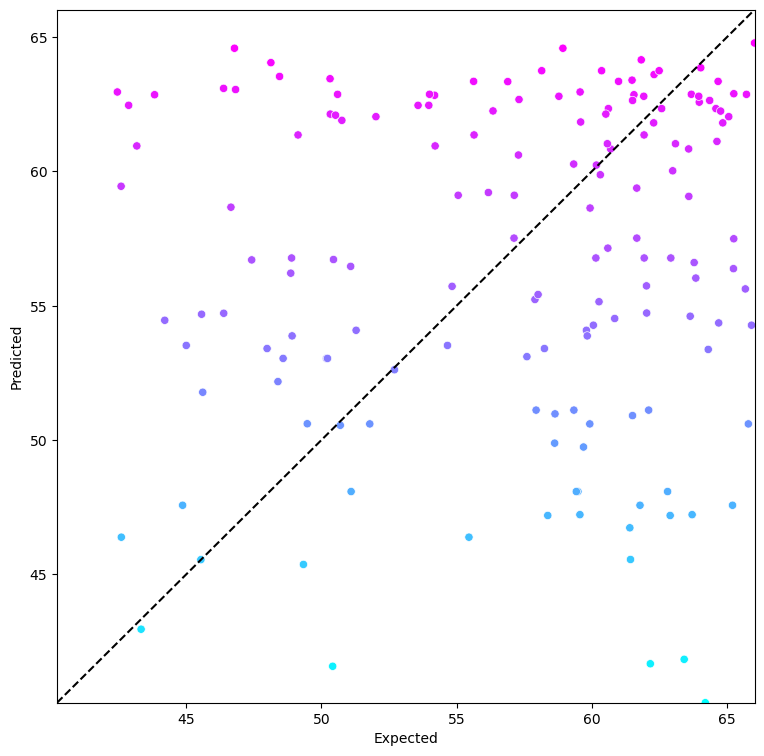

In [253]:
# Visualizing the Expected vs. Predicted
df = pd.DataFrame()
df['Expected'] = pd.Series(expected)
df['Predicted'] = pd.Series(predicted)
figure = plt.figure(figsize=(9,9))
axes = sns.scatterplot(data=df, x= 'Expected', y='Predicted', hue='Predicted', palette='cool', legend=False)

# Set the x- and y-axes limits to use the same scale along both axes
start = min(expected.min(), predicted.min())
end = max(expected.max(), predicted.max())
axes.set_xlim(start, end)
axes.set_ylim(start, end)

line = plt.plot([start, end], [start, end], 'k--')
plt.savefig(plotpath)

In [254]:
# Regression Model Metrics
regressors[user_input] = {'model': 'LinearRegression', 'NOCT':noct_est, 'R_SQUARE':metrics.r2_score(expected, predicted), 'MEAN_SQUARE_ERROR':metrics.mean_squared_error(expected, predicted)}
print(f'R_SQUARE = {metrics.r2_score(expected, predicted)}')
print(f'MSE = {metrics.mean_squared_error(expected, predicted)}')

R_SQUARE = 0.7906593313897057
MSE = 8.934362359772102


# Choosing the best Model

In [281]:
# Let's run several regression estimators
estimators = {
    'LinearRegression': linear_regression,
    'ElasticNet': ElasticNet(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

In [282]:
# We run estimators using k-fold cross-validation with a KFold object and the cross_val_score function
for estimator_name, estimator_object in estimators.items():
    kfold = KFold(n_splits=10, random_state=11, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, X=combined_df[feature_names], y=combined_df[target], cv=kfold, scoring='r2')
    mse = cross_val_score(estimator=estimator_object, X=combined_df[feature_names], y=combined_df[target], cv=kfold, scoring='neg_mean_squared_error')
    print(f'{estimator_name:>16}: mean of r2 scores = {scores.mean():.3f} **** mean of MSE scores = {mse.mean():.2f}')

LinearRegression: mean of r2 scores = 0.766 **** mean of MSE scores = -9.37
      ElasticNet: mean of r2 scores = 0.745 **** mean of MSE scores = -10.26
           Lasso: mean of r2 scores = 0.745 **** mean of MSE scores = -10.26
           Ridge: mean of r2 scores = 0.766 **** mean of MSE scores = -9.37


# Using Deep Learning

In [257]:
# Import the necessary libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy
from keras.optimizers import Adam
import keras
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
import pandas as pd 
from sklearn.preprocessing import LabelEncoder 

In [258]:
# Split into training and testing windows
X_train, X_test, y_train, y_test = train_test_split(combined_df[feature_names], combined_df[target], random_state=11)

In [259]:
'''
# initializing the tunner 
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=1300,
                    )
'''

"\n# initializing the tunner \ntuner = kt.Hyperband(model_builder,\n                     objective='val_loss',\n                     max_epochs=1300,\n                    )\n"

In [260]:
# Early stopping in keras
# The patience parameter represents the number of epochs with no improvement after training is stopped.
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 50)

In [261]:
'''
# First, let us search for the optimum number of nodes in the hidden layer by running the tunner.search() method.
# Seaching the tunner 
tuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# printing the optimal number of nodes 
print('The optimal number of node in the hidden layer is: ', best_hps.get('units'))
'''

"\n# First, let us search for the optimum number of nodes in the hidden layer by running the tunner.search() method.\n# Seaching the tunner \ntuner.search(X_train, y_train, validation_data=(X_test, y_test), callbacks=[stop_early])\n# Get the optimal hyperparameters\nbest_hps=tuner.get_best_hyperparameters(num_trials=1)[0]\n# printing the optimal number of nodes \nprint('The optimal number of node in the hidden layer is: ', best_hps.get('units'))\n"

In [262]:
'''
# creating model with the optimum parameters
model = tuner.hypermodel.build(best_hps)
# fixed max max epohcs to 1300
#Training_model = model.fit(X_train, y_train, epochs=1300, validation_split=0.2, callbacks=[stop_early])
# val_loss 
#val_acc_per_epoch = Training_model.history['val_loss']
# printing optimum eppoc
#best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
#print('Best epoch:',  best_epoch)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1300, batch_size=100, verbose=2, callbacks=[stop_early])
'''

"\n# creating model with the optimum parameters\nmodel = tuner.hypermodel.build(best_hps)\n# fixed max max epohcs to 1300\n#Training_model = model.fit(X_train, y_train, epochs=1300, validation_split=0.2, callbacks=[stop_early])\n# val_loss \n#val_acc_per_epoch = Training_model.history['val_loss']\n# printing optimum eppoc\n#best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1\n#print('Best epoch:',  best_epoch)\nhistory = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1300, batch_size=100, verbose=2, callbacks=[stop_early])\n"

In [263]:
'''
# Creating modele complinin
model = tf.keras.Sequential([tf.keras.layers.InputLayer(
    input_shape=4,),
  tf.keras.layers.Dense(best_hps, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1)
])
# Complining the model
model.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])
# training the model on optimum epochs
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1300, batch_size=100, verbose=2, callbacks=[stop_early])
'''

"\n# Creating modele complinin\nmodel = tf.keras.Sequential([tf.keras.layers.InputLayer(\n    input_shape=4,),\n  tf.keras.layers.Dense(best_hps, activation = tf.keras.activations.relu),\n  tf.keras.layers.Dense(1)\n])\n# Complining the model\nmodel.compile(loss=tf.keras.losses.mae,\n                optimizer=tf.keras.optimizers.Adam(),\n                metrics=['mae'])\n# training the model on optimum epochs\nhistory = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1300, batch_size=100, verbose=2, callbacks=[stop_early])\n"

In [264]:
# Let's set the model training for a very long time, 
# but with an EarlyStopping callback so it stops automatically when it stops improving.
model = create_model()
history = fit_model(model, 'val_loss', 100000)

Epoch 1/100000


C:\Users\Kuitche\anaconda3\envs\dev\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 - 0s - loss: 8003.0596 - val_loss: 3832.2434 - 419ms/epoch - 84ms/step
Epoch 2/100000
5/5 - 0s - loss: 3472.8689 - val_loss: 3338.9756 - 38ms/epoch - 8ms/step
Epoch 3/100000
5/5 - 0s - loss: 3357.6597 - val_loss: 3373.6589 - 35ms/epoch - 7ms/step
Epoch 4/100000
5/5 - 0s - loss: 3360.7380 - val_loss: 3344.0754 - 32ms/epoch - 6ms/step
Epoch 5/100000
5/5 - 0s - loss: 3344.8528 - val_loss: 3318.6128 - 41ms/epoch - 8ms/step
Epoch 6/100000
5/5 - 0s - loss: 3320.6472 - val_loss: 3252.7471 - 32ms/epoch - 6ms/step
Epoch 7/100000
5/5 - 0s - loss: 3259.2715 - val_loss: 3137.2878 - 32ms/epoch - 6ms/step
Epoch 8/100000
5/5 - 0s - loss: 3111.9175 - val_loss: 2888.6243 - 34ms/epoch - 7ms/step
Epoch 9/100000
5/5 - 0s - loss: 2703.6260 - val_loss: 2125.3442 - 33ms/epoch - 7ms/step
Epoch 10/100000
5/5 - 0s - loss: 1587.3704 - val_loss: 855.9344 - 34ms/epoch - 7ms/step
Epoch 11/100000
5/5 - 0s - loss: 494.1453 - val_loss: 190.6384 - 32ms/epoch - 6ms/step
Epoch 12/100000
5/5 - 0s - loss: 109.8047 - va

In [265]:
# define filename for saving the model and history
filepath = 'models/dnn_noct_' + user_input

# Save a model using the HDF5 format
saving_model(model, filepath+'.h5')

# Save history
saving_history(history, filepath)

In [266]:
# Load a model from the HDF5 format
model = loading_model(filepath + ".h5")
model.summary()

# Load history
history_dict = loading_history(filepath)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                320       
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dense_10 (Dense)            (None, 4)                 68        
                                                                 
 dense_11 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1,433
Trainable params: 1,433
Non-trainable params: 0
_________________________________________________________________


6/6 [==============================] - 0s 1ms/step


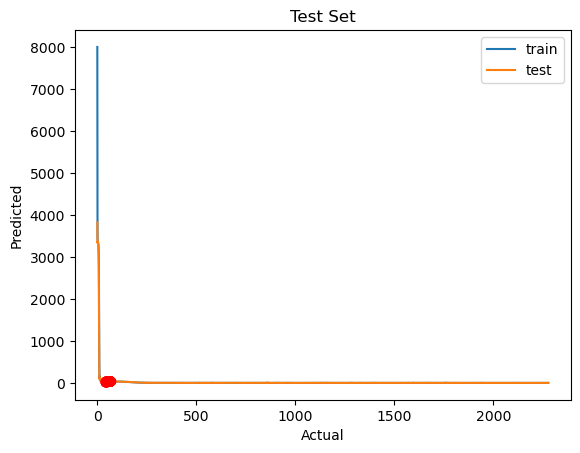

In [267]:
# Calculate predictions
predictions = calculate_predictions(model)

# define filepath for plots
filepath = 'plots/dnn_noct_' + user_input

# Plot training history 
plot_training(history_dict, filepath + "_training")

# Plot actual vs prediction for training set
actual_prediction_plot(y_train, predictions['train'], 'Training Set', filepath+"_train")

# Plot actual vs prediction for validation set
actual_prediction_plot(y_test, predictions['test'], 'Test Set', filepath+"_test")

In [268]:
# Compute score values for training set
# Note that this returns a list of scores.The first index is r_quare and the second index is mse
scores_train = compute_metrics(y_train, predictions['train'])
r_square_train = scores_train[0]
mse_train = scores_train[1]

# Compute score values for training set
scores_test = compute_metrics(y_test, predictions['test'])
r_square_test = scores_test[0]
mse_test = scores_test[1]

# Estimate NOCT
noct = compute_noct(model)

1/1 [==============================] - 0s 53ms/step


In [269]:
# Print the results
print("NOCT = {:.2f}".format( noct ))
print("R_SQUARE Train = {:.2f}".format( r_square_train ))
print("MSE Train = {:.2f}".format( mse_train ))
print("R_SQUARE Test = {:.2f}".format( r_square_test ))
print("MSE Test = {:.2f}".format( mse_test ))


NOCT = 44.17
R_SQUARE Train = 0.75
MSE Train = 10.42
R_SQUARE Test = 0.74
MSE Test = 11.19


In [270]:
'''
# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
'''

"\n# Plot training history\nplt.plot(history.history['loss'], label='train')\nplt.plot(history.history['val_loss'], label='test')\nplt.legend()\nplt.show()\n"

In [271]:
'''
# Plot actual vs prediction for training set
plt.plot(y_train,PredTestSet,'ro')
plt.title('Training Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for training set
TestR2Value = metrics.r2_score(y_train,PredTestSet)
print("Training Set R-Square=", TestR2Value)
'''

'\n# Plot actual vs prediction for training set\nplt.plot(y_train,PredTestSet,\'ro\')\nplt.title(\'Training Set\')\nplt.xlabel(\'Actual\')\nplt.ylabel(\'Predicted\')\n\n# Compute R-Square value for training set\nTestR2Value = metrics.r2_score(y_train,PredTestSet)\nprint("Training Set R-Square=", TestR2Value)\n'

In [272]:
'''
# Plot actual vs prediction for validation set
plt.plot(y_test,PredValSet,'ro')
plt.title('Test Set')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Compute R-Square value for validation set
ValR2Value = metrics.r2_score(y_test,PredValSet)
print("Test Set R-Square=",ValR2Value)
'''

'\n# Plot actual vs prediction for validation set\nplt.plot(y_test,PredValSet,\'ro\')\nplt.title(\'Test Set\')\nplt.xlabel(\'Actual\')\nplt.ylabel(\'Predicted\')\n\n# Compute R-Square value for validation set\nValR2Value = metrics.r2_score(y_test,PredValSet)\nprint("Test Set R-Square=",ValR2Value)\n'

In [273]:
#X_test

In [274]:
'''
x = pd.DataFrame(columns=['irradiance', 'wind_speed', 'wind_direction', 'ambient_temperature'])
x.loc[0] = [800,1,120,20]
x = np.asarray(x)
x=tf.convert_to_tensor(x, dtype=tf.int32)
display(x)
#display(X_test.head(2))
y_pred = model.predict(x)
noct = float("{:.2f}".format( y_pred[0][0] ))
#print("NOCT = {:.2f}".format( noct ))
'''

'\nx = pd.DataFrame(columns=[\'irradiance\', \'wind_speed\', \'wind_direction\', \'ambient_temperature\'])\nx.loc[0] = [800,1,120,20]\nx = np.asarray(x)\nx=tf.convert_to_tensor(x, dtype=tf.int32)\ndisplay(x)\n#display(X_test.head(2))\ny_pred = model.predict(x)\nnoct = float("{:.2f}".format( y_pred[0][0] ))\n#print("NOCT = {:.2f}".format( noct ))\n'

In [275]:
'''
# Load a model from the HDF5 format
loaded_h5_model = loading_model("dnn_noct.h5")
loaded_h5_model.summary()
'''

'\n# Load a model from the HDF5 format\nloaded_h5_model = loading_model("dnn_noct.h5")\nloaded_h5_model.summary()\n'